In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from xgboost import XGBClassifier
plt.style.use('fivethirtyeight')

# 1. Loading the Dataset

In [2]:
df = pd.read_csv('Diabetes_Dataset.csv')
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,cholesterol,blood_pressure,diabetes
0,Female,80.0,0.0,1.0,never,25.19,6.6,140.0,NaN,82.30,0.0
1,Male,28.0,0.0,0.0,never,27.32,5.7,158.0,NaN,123.47,0.0
2,Female,36.0,0.0,0.0,current,23.45,5.0,155.0,209.43,120.50,0.0
3,Male,76.0,1.0,1.0,current,20.14,4.8,155.0,235.69,148.71,0.0
4,Female,20.0,0.0,0.0,never,27.32,NaN,85.0,182.98,147.76,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,Male,42.0,0.0,0.0,current,25.18,NaN,130.0,212.80,139.15,0.0
99996,Female,17.0,0.0,0.0,never,27.32,NaN,155.0,223.97,110.74,0.0
99997,Female,51.0,0.0,0.0,ever,29.28,5.7,158.0,173.60,102.19,0.0
99998,Female,80.0,0.0,NaN,never,25.33,5.8,140.0,239.77,109.98,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               97620 non-null  object 
 1   age                  97009 non-null  float64
 2   hypertension         96851 non-null  float64
 3   heart_disease        96438 non-null  float64
 4   smoking_history      95999 non-null  object 
 5   bmi                  97950 non-null  float64
 6   HbA1c_level          96264 non-null  float64
 7   blood_glucose_level  96609 non-null  float64
 8   cholesterol          96065 non-null  float64
 9   blood_pressure       95206 non-null  float64
 10  diabetes             98741 non-null  float64
dtypes: float64(9), object(2)
memory usage: 8.4+ MB


In [4]:
df.describe() # About 10% people have diabetes

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,cholesterol,blood_pressure,diabetes
count,97009.000000,96851.000000,96438.000000,97950.000000,96264.000000,96609.000000,96065.000000,95206.000000,98741.000000
mean,46.552536,0.098801,0.046444,28.433802,5.566924,139.494737,189.991404,120.029398,0.109620
std,19.510089,0.298397,0.210447,6.526150,1.096303,42.175488,30.018670,14.930484,0.312417
min,0.160000,0.000000,0.000000,10.080000,3.500000,80.000000,100.000000,80.000000,0.000000
25%,31.000000,0.000000,0.000000,24.600000,4.800000,100.000000,169.630000,109.970000,0.000000
50%,47.000000,0.000000,0.000000,27.320000,5.800000,140.000000,190.060000,120.070000,0.000000
75%,61.000000,0.000000,0.000000,31.100000,6.200000,159.000000,210.340000,130.090000,0.000000
max,80.000000,1.000000,1.000000,91.820000,9.000000,300.000000,300.000000,180.000000,1.000000


In [5]:
df['gender'].value_counts()

gender
Female    58988
Male      38614
Other        18
Name: count, dtype: int64

In [6]:
df = df[ df['gender']!='Other' ]

In [7]:
df['gender'].value_counts()

gender
Female    58988
Male      38614
Name: count, dtype: int64

In [8]:
df['smoking_history'].value_counts()

smoking_history
never          52430
former         13992
current        13895
not current     9687
ever            5978
Name: count, dtype: int64

In [9]:
# not current -> former (assuming)
df.loc[:, 'smoking_history'] = df['smoking_history'].replace('not current', 'former')

# now distributing 'ever' proportionally b/w former and current
f_cnt = 13992 # former smokers
c_cnt = 13895 # current smokers
t = f_cnt + c_cnt

f_frac = f_cnt/t
c_frac = c_cnt/t
# f_frac + c_frac = 1

np.random.seed(42)
ever_i = df[ df['smoking_history']=='ever' ].index
n = len(ever_i)

# Randomly choosing roughly 50% of 'ever' and label them to 'former'
# Remaining roughly 50% of 'ever' and label them to 'current'
assign = np.random.choice(
    ['former', 'current'],
    size=n,
    p=[f_frac, c_frac]
)

df.loc[ever_i, 'smoking_history'] = assign

In [10]:
df['smoking_history'].value_counts()

smoking_history
never      52430
former     26688
current    16864
Name: count, dtype: int64

### All the entries are non-null

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99982 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               97602 non-null  object 
 1   age                  96992 non-null  float64
 2   hypertension         96834 non-null  float64
 3   heart_disease        96422 non-null  float64
 4   smoking_history      95982 non-null  object 
 5   bmi                  97932 non-null  float64
 6   HbA1c_level          96246 non-null  float64
 7   blood_glucose_level  96591 non-null  float64
 8   cholesterol          96047 non-null  float64
 9   blood_pressure       95190 non-null  float64
 10  diabetes             98723 non-null  float64
dtypes: float64(9), object(2)
memory usage: 11.2+ MB


In [12]:
df.describe() # ---- SKEWED DATASET

# According the WHO, if 25<= bmi <=30, overweight category (Yes, its a real data) - most of the patients are over-weight (50% is 27.32)
# Normal blood glucose levels typically fall between 70-130 mg/dL before meals and below 180 mg/dL after meals for adults
# Average Cholestrol levels are normal actually (should be <= 200 mg/dL)
# Blood Pressure should be <= 120mmHg (Is it not good)

### HbA1c Test (A normal HbA1c level is below 5.7%,)
# HbA1c, or glycated hemoglobin, is a blood test that indicates your average blood sugar levels over the past 2-3 months.
# The test measures the percentage of hemoglobin, a protein in red blood cells, that has sugar attached to it

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,cholesterol,blood_pressure,diabetes
count,96992.000000,96834.000000,96422.000000,97932.000000,96246.000000,96591.000000,96047.000000,95190.000000,98723.000000
mean,46.555994,0.098819,0.046452,28.433953,5.566900,139.497769,189.992825,120.028748,0.109640
std,19.509144,0.298420,0.210463,6.526023,1.096332,42.176294,30.018348,14.930850,0.312442
min,0.160000,0.000000,0.000000,10.080000,3.500000,80.000000,100.000000,80.000000,0.000000
25%,31.000000,0.000000,0.000000,24.600000,4.800000,100.000000,169.640000,109.970000,0.000000
50%,47.000000,0.000000,0.000000,27.320000,5.800000,140.000000,190.060000,120.070000,0.000000
75%,61.000000,0.000000,0.000000,31.100000,6.200000,159.000000,210.340000,130.090000,0.000000
max,80.000000,1.000000,1.000000,91.820000,9.000000,300.000000,300.000000,180.000000,1.000000


# 2. Preprocessing the Data

### (a) Handline Missing Values

In [13]:
# Clearing the diabetes rows with missing values
df = df.dropna(subset = ['diabetes'])
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,cholesterol,blood_pressure,diabetes
0,Female,80.0,0.0,1.0,never,25.19,6.6,140.0,NaN,82.30,0.0
1,Male,28.0,0.0,0.0,never,27.32,5.7,158.0,NaN,123.47,0.0
2,Female,36.0,0.0,0.0,current,23.45,5.0,155.0,209.43,120.50,0.0
3,Male,76.0,1.0,1.0,current,20.14,4.8,155.0,235.69,148.71,0.0
4,Female,20.0,0.0,0.0,never,27.32,NaN,85.0,182.98,147.76,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,Male,42.0,0.0,0.0,current,25.18,NaN,130.0,212.80,139.15,0.0
99996,Female,17.0,0.0,0.0,never,27.32,NaN,155.0,223.97,110.74,0.0
99997,Female,51.0,0.0,0.0,former,29.28,5.7,158.0,173.60,102.19,0.0
99998,Female,80.0,0.0,NaN,never,25.33,5.8,140.0,239.77,109.98,0.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98723 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96370 non-null  object 
 1   age                  95772 non-null  float64
 2   hypertension         95608 non-null  float64
 3   heart_disease        95221 non-null  float64
 4   smoking_history      94778 non-null  object 
 5   bmi                  96691 non-null  float64
 6   HbA1c_level          95029 non-null  float64
 7   blood_glucose_level  95383 non-null  float64
 8   cholesterol          94838 non-null  float64
 9   blood_pressure       94002 non-null  float64
 10  diabetes             98723 non-null  float64
dtypes: float64(9), object(2)
memory usage: 9.0+ MB


In [15]:
df.isnull().sum()

gender                 2353
age                    2951
hypertension           3115
heart_disease          3502
smoking_history        3945
bmi                    2032
HbA1c_level            3694
blood_glucose_level    3340
cholesterol            3885
blood_pressure         4721
diabetes                  0
dtype: int64

In [16]:
# handiling missing values
# Using median for the numerical and mode for the categorical data
cat_list = ['gender', 'hypertension', 'heart_disease', 'smoking_history']
num_list = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'cholesterol', 'blood_pressure']
# Handline categorical data with mode


In [17]:
for col in cat_list:
    mode = df[col].mode()[0]
    df.loc[:, col] = df[col].fillna(mode)

In [18]:
for col in num_list:
    median = df[col].median()
    df.loc[:, col] = df[col].fillna(median)

In [19]:
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,cholesterol,blood_pressure,diabetes
0,Female,80.0,0.0,1.0,never,25.19,6.6,140.0,190.04,82.30,0.0
1,Male,28.0,0.0,0.0,never,27.32,5.7,158.0,190.04,123.47,0.0
2,Female,36.0,0.0,0.0,current,23.45,5.0,155.0,209.43,120.50,0.0
3,Male,76.0,1.0,1.0,current,20.14,4.8,155.0,235.69,148.71,0.0
4,Female,20.0,0.0,0.0,never,27.32,5.8,85.0,182.98,147.76,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,Male,42.0,0.0,0.0,current,25.18,5.8,130.0,212.80,139.15,0.0
99996,Female,17.0,0.0,0.0,never,27.32,5.8,155.0,223.97,110.74,0.0
99997,Female,51.0,0.0,0.0,former,29.28,5.7,158.0,173.60,102.19,0.0
99998,Female,80.0,0.0,0.0,never,25.33,5.8,140.0,239.77,109.98,0.0


In [20]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
cholesterol            0
blood_pressure         0
diabetes               0
dtype: int64

In [21]:
df = df.drop_duplicates()

In [22]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,cholesterol,blood_pressure,diabetes
count,64262.000000,64262.000000,64262.000000,64262.000000,64262.000000,64262.000000,64262.000000,64262.000000,64262.000000
mean,46.587090,0.095048,0.045859,28.404640,5.574156,139.567116,190.036865,120.032697,0.109878
std,19.203155,0.293284,0.209181,6.453662,1.076317,41.441460,29.410042,14.566521,0.312740
min,0.160000,0.000000,0.000000,10.080000,3.500000,80.000000,100.000000,80.000000,0.000000
25%,31.000000,0.000000,0.000000,24.700000,4.800000,100.000000,170.710000,110.570000,0.000000
50%,47.000000,0.000000,0.000000,27.320000,5.800000,140.000000,190.040000,120.070000,0.000000
75%,61.000000,0.000000,0.000000,30.960000,6.200000,159.000000,209.420000,129.430000,0.000000
max,80.000000,1.000000,1.000000,91.820000,9.000000,300.000000,300.000000,180.000000,1.000000


In [23]:
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,cholesterol,blood_pressure,diabetes
0,Female,80.0,0.0,1.0,never,25.19,6.6,140.0,190.04,82.30,0.0
1,Male,28.0,0.0,0.0,never,27.32,5.7,158.0,190.04,123.47,0.0
2,Female,36.0,0.0,0.0,current,23.45,5.0,155.0,209.43,120.50,0.0
3,Male,76.0,1.0,1.0,current,20.14,4.8,155.0,235.69,148.71,0.0
4,Female,20.0,0.0,0.0,never,27.32,5.8,85.0,182.98,147.76,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99876,Female,26.0,0.0,0.0,former,23.86,4.8,160.0,188.52,105.48,0.0
99974,Female,60.0,0.0,0.0,current,27.32,4.8,160.0,147.50,127.31,0.0
99976,Male,27.0,0.0,0.0,former,25.78,4.0,100.0,186.59,120.50,0.0
99979,Female,68.0,0.0,1.0,current,23.80,6.6,140.0,213.39,125.76,0.0


### (b) Using Categorical Encoder Labeling

In [24]:
for col in cat_list:
    print(df[col].unique())
    # using different label encoder for every column to avoild any incorrect mapping
    label_encoder = LabelEncoder()
    df.loc[:, col] = label_encoder.fit_transform(df[col])

df

['Female' 'Male']
[0. 1.]
[1. 0.]
['never' 'current' 'former']


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,cholesterol,blood_pressure,diabetes
0,0,80.0,0.0,1.0,2,25.19,6.6,140.0,190.04,82.30,0.0
1,1,28.0,0.0,0.0,2,27.32,5.7,158.0,190.04,123.47,0.0
2,0,36.0,0.0,0.0,0,23.45,5.0,155.0,209.43,120.50,0.0
3,1,76.0,1.0,1.0,0,20.14,4.8,155.0,235.69,148.71,0.0
4,0,20.0,0.0,0.0,2,27.32,5.8,85.0,182.98,147.76,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99876,0,26.0,0.0,0.0,1,23.86,4.8,160.0,188.52,105.48,0.0
99974,0,60.0,0.0,0.0,0,27.32,4.8,160.0,147.50,127.31,0.0
99976,1,27.0,0.0,0.0,1,25.78,4.0,100.0,186.59,120.50,0.0
99979,0,68.0,0.0,1.0,0,23.80,6.6,140.0,213.39,125.76,0.0


In [25]:
haveDiabetes = df[ df['diabetes'] == 1 ]
notDiabetes = df[ df['diabetes'] == 0 ]

notDiabetes = notDiabetes.sample(n = 20000)
df = pd.concat([haveDiabetes, notDiabetes])

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27061 entries, 5 to 61054
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               27061 non-null  object 
 1   age                  27061 non-null  float64
 2   hypertension         27061 non-null  float64
 3   heart_disease        27061 non-null  float64
 4   smoking_history      27061 non-null  object 
 5   bmi                  27061 non-null  float64
 6   HbA1c_level          27061 non-null  float64
 7   blood_glucose_level  27061 non-null  float64
 8   cholesterol          27061 non-null  float64
 9   blood_pressure       27061 non-null  float64
 10  diabetes             27061 non-null  float64
dtypes: float64(9), object(2)
memory usage: 2.5+ MB


In [27]:
X = df.drop(columns = ['diabetes'])
y = df['diabetes']

In [28]:
X

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,cholesterol,blood_pressure
5,0,44.0,0.0,0.0,2,19.31,6.5,200.0,182.98,130.20
19,1,67.0,0.0,1.0,1,27.32,6.5,200.0,147.63,124.12
27,1,50.0,1.0,0.0,0,27.32,5.7,260.0,201.27,135.63
29,1,73.0,0.0,0.0,1,25.91,9.0,160.0,181.25,135.28
36,0,53.0,0.0,0.0,1,27.32,7.0,159.0,196.27,104.46
...,...,...,...,...,...,...,...,...,...,...
43532,0,47.0,0.0,0.0,2,39.30,3.5,155.0,143.95,133.94
49730,0,43.0,0.0,0.0,0,22.70,4.8,126.0,198.39,133.49
25224,1,30.0,1.0,0.0,2,34.80,6.1,159.0,158.62,103.59
12931,1,49.0,1.0,0.0,1,46.65,4.8,90.0,171.25,130.22


In [29]:
y

5        1.0
19       1.0
27       1.0
29       1.0
36       1.0
        ... 
43532    0.0
49730    0.0
25224    0.0
12931    0.0
61054    0.0
Name: diabetes, Length: 27061, dtype: float64

### (c) Data Visualization

Text(0.5, 1.0, 'Correlation Heatmap / Varience-Covarience Matrix')

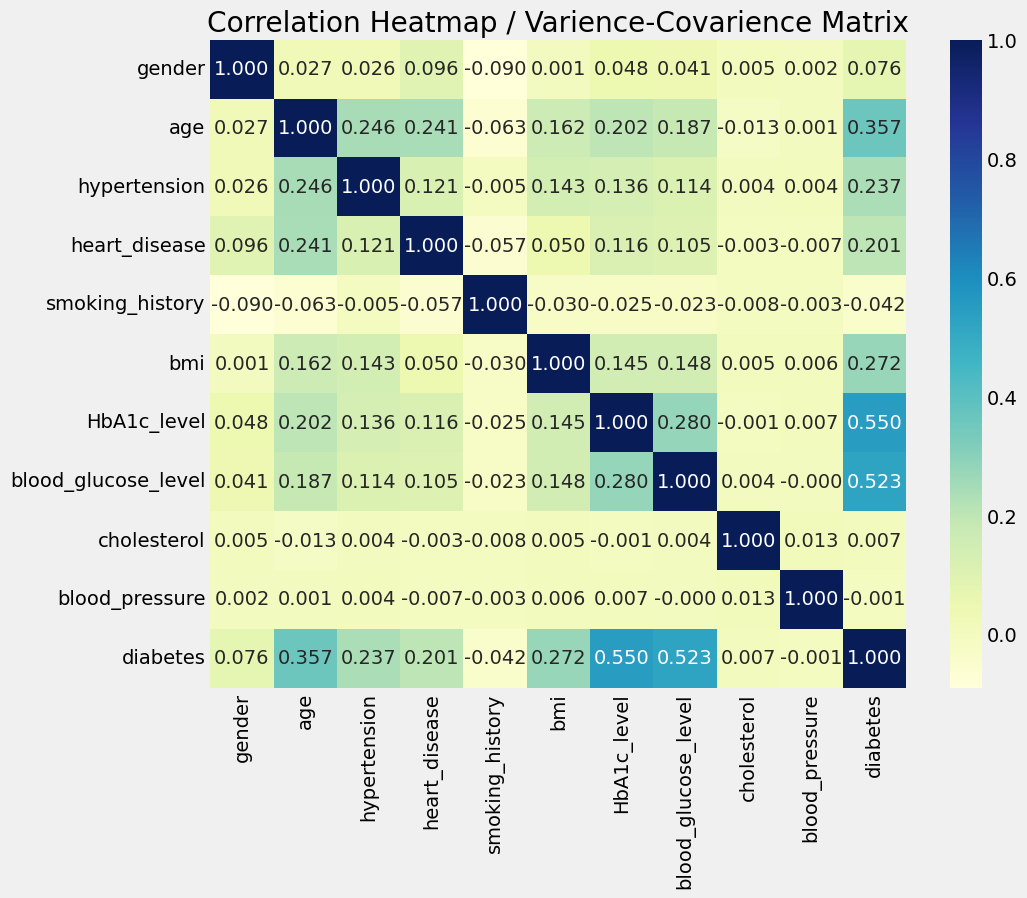

In [30]:
plt.figure(figsize = (10,8))
sns.heatmap(df.corr(), annot=True, fmt='.3f', cmap='YlGnBu')
plt.title('Correlation Heatmap / Varience-Covarience Matrix')

C:\Users\91797\AppData\Local\Temp\ipykernel_16068\1920540438.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_diabetes = df.groupby(age_groups)['diabetes'].sum().reset_index()


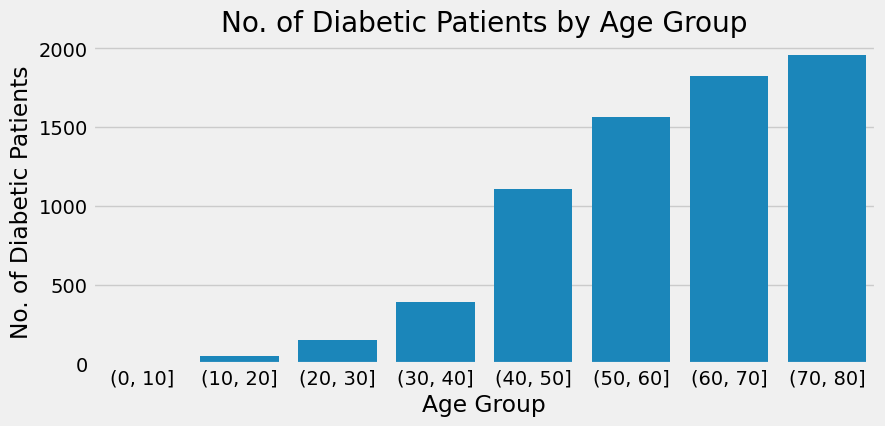

In [31]:
# sns.relplot(x='blood_glucose_level', y='diabetes', data=dataset)
# sns.relplot(x='cholesterol', y='diabetes', data=dataset)

# plt.figure(figsize = (10,5))

# sns.lineplot(x = df['age'], y = df['diabetes'], color = 'green')
# plt.title('Age vs Diabetes',fontsize=20,fontweight='bold')
# plt.xlabel('Age',fontsize=16)
# plt.ylabel('Diabates',fontsize=16)
# plt.show()

plt.figure(figsize = (9,4))
age_groups = pd.cut(df['age'], bins=range(0, 90, 10))
age_diabetes = df.groupby(age_groups)['diabetes'].sum().reset_index()

sns.barplot(x='age', y='diabetes', data=age_diabetes)
plt.title('No. of Diabetic Patients by Age Group')
plt.xlabel('Age Group')
plt.ylabel('No. of Diabetic Patients')
plt.show()


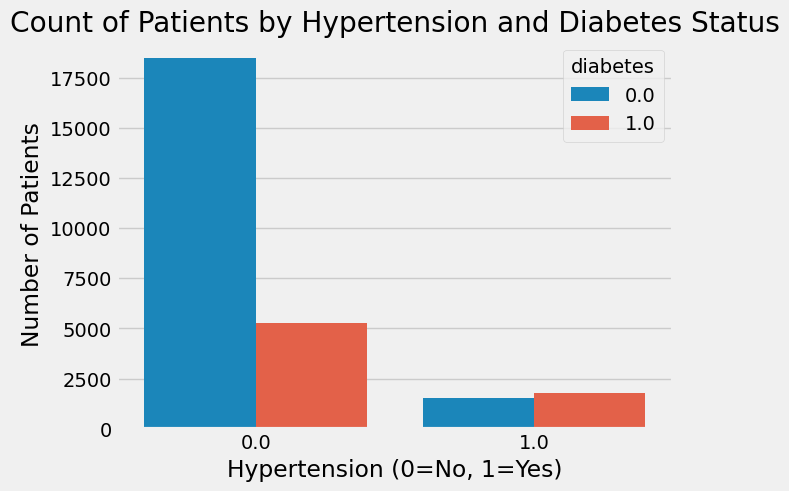

In [32]:
count_data = df.groupby(['hypertension', 'diabetes']).size().reset_index(name='count')

sns.barplot(x='hypertension', y='count', hue='diabetes', data=count_data)
plt.title('Count of Patients by Hypertension and Diabetes Status')
plt.xlabel('Hypertension (0=No, 1=Yes)')
plt.ylabel('Number of Patients')
plt.show()

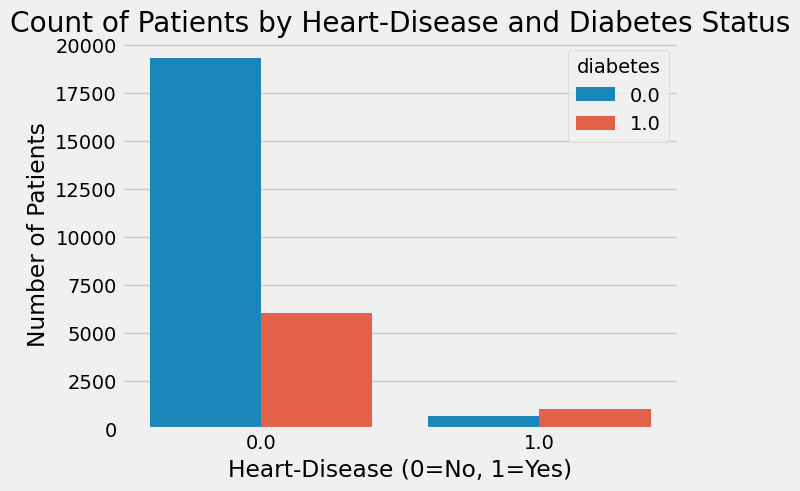

In [33]:
count_data = df.groupby(['heart_disease', 'diabetes']).size().reset_index(name='count')

sns.barplot(x='heart_disease', y='count', hue='diabetes', data=count_data)
plt.title('Count of Patients by Heart-Disease and Diabetes Status')
plt.xlabel('Heart-Disease (0=No, 1=Yes)')
plt.ylabel('Number of Patients')
plt.show()

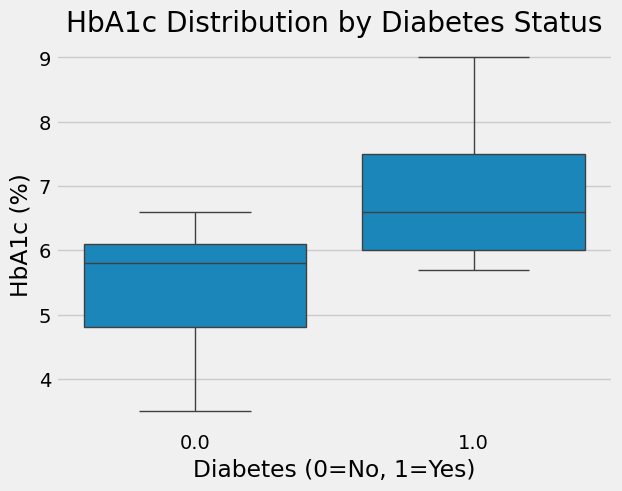

In [34]:
# plt.figure(figsize = (10,5))
# sns.lineplot(x = df['HbA1c_level'], y = df['diabetes'], color = 'green')
# plt.title('HbA1c_level vs Diabetes',fontsize=20,fontweight='bold')
# plt.xlabel('HbA1c_level',fontsize=16)
# plt.ylabel('Diabates',fontsize=16)
# plt.show()

sns.boxplot(x='diabetes', y='HbA1c_level', data=df)
plt.title('HbA1c Distribution by Diabetes Status')
plt.xlabel('Diabetes (0=No, 1=Yes)')
plt.ylabel('HbA1c (%)')
plt.show()


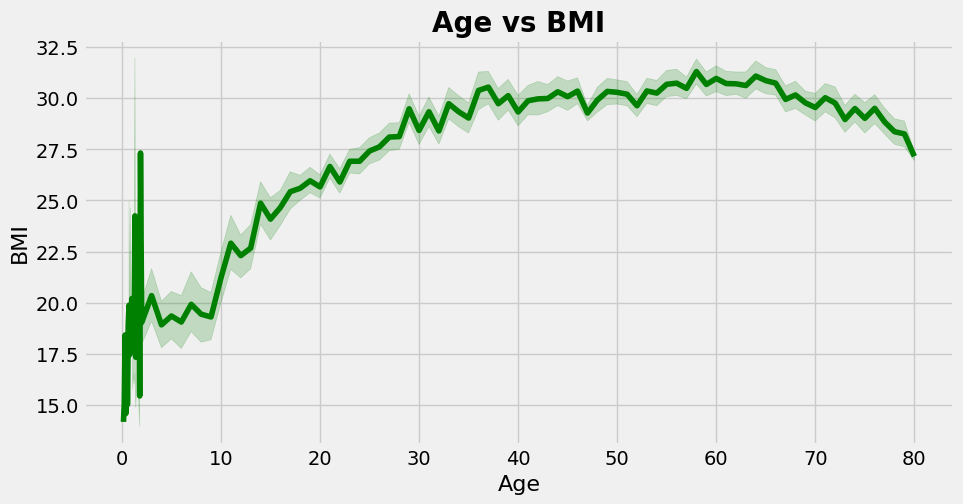

In [35]:
plt.figure(figsize = (10,5))
sns.lineplot(x = df['age'], y = df['bmi'], color = 'green')
plt.title('Age vs BMI',fontsize=20,fontweight='bold')
plt.xlabel('Age',fontsize=16)
plt.ylabel('BMI',fontsize=16)
plt.show()# At the end Random forest classifier works best

### (c) Scaling Features

In [36]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-8.15403269e-01, -2.58961569e-01, -3.71254013e-01, ...,
         1.05455395e+00, -2.43218690e-01,  6.89063062e-01],
       [ 1.22638704e+00,  9.37118278e-01, -3.71254013e-01, ...,
         1.05455395e+00, -1.43721162e+00,  2.71440698e-01],
       [ 1.22638704e+00,  5.30592606e-02,  2.69357358e+00, ...,
         2.28189717e+00,  3.74550213e-01,  1.06203830e+00],
       ...,
       [ 1.22638704e+00, -9.87010171e-01,  2.69357358e+00, ...,
         2.15869419e-01, -1.06600986e+00, -1.13872166e+00],
       [ 1.22638704e+00,  1.05578904e-03,  2.69357358e+00, ...,
        -1.19557529e+00, -6.39414929e-01,  6.90436820e-01],
       [-8.15403269e-01, -1.09101711e+00, -3.71254013e-01, ...,
        -1.19557529e+00,  6.23819458e-01, -6.51724528e-01]])

<!-- X = scaler.fit_transform(X) -->
<!-- X -->

# 3. Model Training (We are more focused toward recall)

### (a) Train-Val-Test splitting

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### (b) Model Selection

In [38]:
## Decision Tree Classifier (Single Tree)
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train, y_train)
print(dt.score(X_train, y_train))
print(dt.score(X_test, y_test))

1.0
0.8965262379896526


In [39]:
# Decision Tree Classifier (Multiple Tree)
# maximum depth say D
epochs = 15
training_accuracy = []
test_accuracy = []

for d in range(1, epochs+1):
    dt = DecisionTreeClassifier(random_state = 42, max_depth = d)
    dt.fit(X_train, y_train)
    training_accuracy.append(dt.score(X_train, y_train))
    test_accuracy.append(dt.score(X_val, y_val))
    

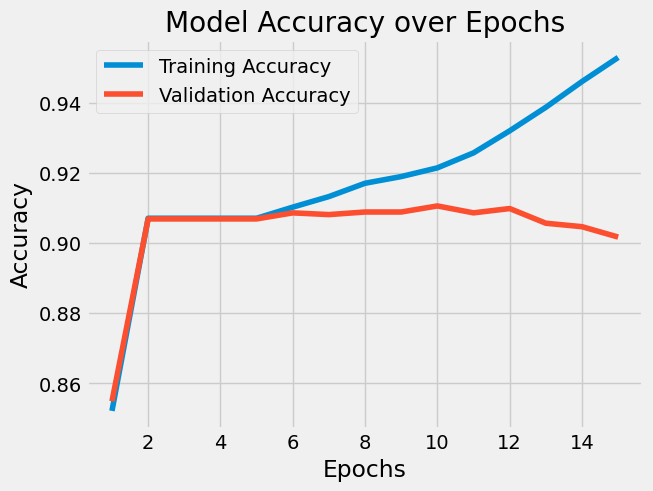

In [40]:
plt.plot(range(1, epochs+1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracy, label='Validation Accuracy')

plt.xlabel('Epochs')  # or 'k value' or any x-axis label
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Iteration #6 looks great
dt = DecisionTreeClassifier(random_state = 42, max_depth = 6)
dt.fit(X_train, y_train)
print(dt.score(X_train, y_train))
print(dt.score(X_val, y_val))

0.9102523492767395
0.9086206896551724


In [42]:
print(dt.score(X_test, y_test))

0.9216555801921655


In [43]:
# RANDOM FOREST
epochs = 20
training_accuracy = []
test_accuracy = []
recall_value = []
precision_value = []

for d in range(1, epochs+1):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = d, class_weight = 'balanced')
    rf.fit(X_train, y_train)
    training_accuracy.append(rf.score(X_train, y_train))
    test_accuracy.append(rf.score(X_val, y_val))

    y_pred = rf.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision_value.append(precision)
    recall_value.append(recall)
    print(f"Iteration ({d})")

Iteration (1)
Iteration (2)
Iteration (3)
Iteration (4)
Iteration (5)
Iteration (6)
Iteration (7)
Iteration (8)
Iteration (9)
Iteration (10)
Iteration (11)
Iteration (12)
Iteration (13)
Iteration (14)
Iteration (15)
Iteration (16)
Iteration (17)
Iteration (18)
Iteration (19)
Iteration (20)


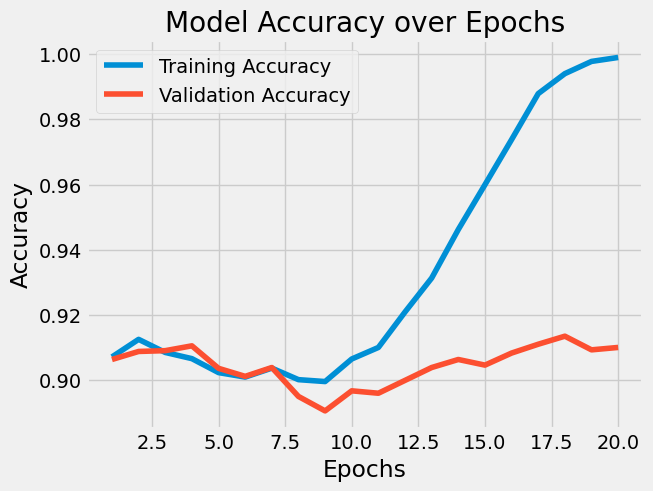

In [44]:
plt.plot(range(1, epochs+1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracy, label='Validation Accuracy')

plt.xlabel('Epochs')  # or 'k value' or any x-axis label
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

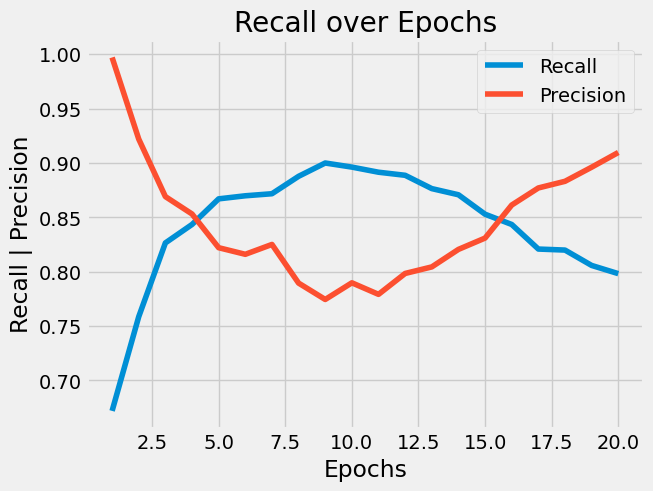

In [45]:
plt.plot(range(1, epochs+1), recall_value, label='Recall')
plt.plot(range(1, epochs+1), precision_value, label='Precision')

plt.xlabel('Epochs')  # or 'k value' or any x-axis label
plt.ylabel('Recall | Precision')
plt.title('Recall over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 15, class_weight = 'balanced')
rf.fit(X_train, y_train)

print(rf.score(X_train, y_train))
print(rf.score(X_val, y_val))

0.9599831063245697
0.9046798029556651


In [47]:
## Observation whenever recall is more than 80%, precision is always lesser than 70%

Train  accuracy: 0.926
Val    accuracy: 0.912
Test   accuracy: 0.919


D:\Python 311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


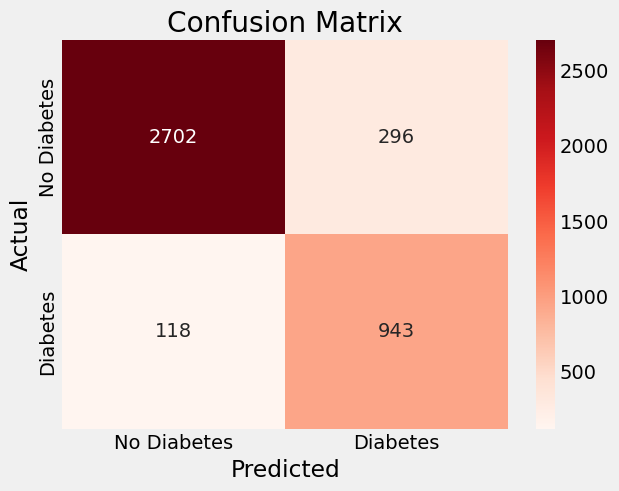

Precision: 0.76
Recall:    0.89
Accuracy:    0.90
F1 Score:    0.82


In [48]:
mlp = MLPClassifier(random_state = 42)
mlp.fit(X_train, y_train)

print("Train  accuracy: {:.3f}".format(mlp.score(X_train, y_train)))
print("Val    accuracy: {:.3f}".format(mlp.score(X_val,   y_val)))
print("Test   accuracy: {:.3f}".format(mlp.score(X_test,  y_test)))

y_proba = mlp.predict_proba(X_test)[:, 1]  # Probability of positive class (Diabetes)
threshold = 0.24  # Lower threshold to increase recall

y_pred = (y_proba >= threshold).astype(int)
CM = confusion_matrix(y_test, y_pred)
labels = ['No Diabetes', 'Diabetes']
sns.heatmap(CM, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision: {:.2f}".format(precision))
print("Recall:    {:.2f}".format(recall))
print("Accuracy:    {:.2f}".format(accuracy))
print("F1 Score:    {:.2f}".format(f1))

In [49]:
# KNN Classifier
epochs = 15
training_accuracy = []
test_accuracy = []
recall_value = []
precision_value = []

for d in range(1, epochs+1):
    knn = KNeighborsClassifier(n_neighbors = d)
    knn.fit(X_train, y_train)
    training_accuracy.append(knn.score(X_train, y_train))
    test_accuracy.append(knn.score(X_val, y_val))
    
    y_pred = knn.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision_value.append(precision)
    recall_value.append(recall)
    print(f"Iteration ({d})")

Iteration (1)
Iteration (2)
Iteration (3)
Iteration (4)
Iteration (5)
Iteration (6)
Iteration (7)
Iteration (8)
Iteration (9)
Iteration (10)
Iteration (11)
Iteration (12)
Iteration (13)
Iteration (14)
Iteration (15)


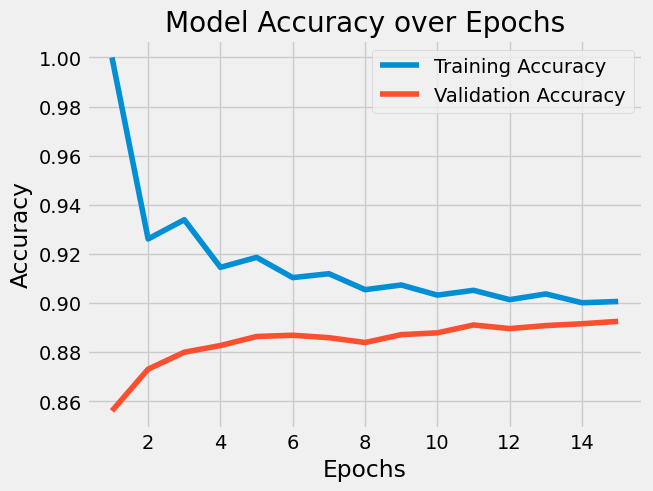

In [50]:
plt.plot(range(1, epochs+1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracy, label='Validation Accuracy')

plt.xlabel('Epochs')  # or 'k value' or any x-axis label
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

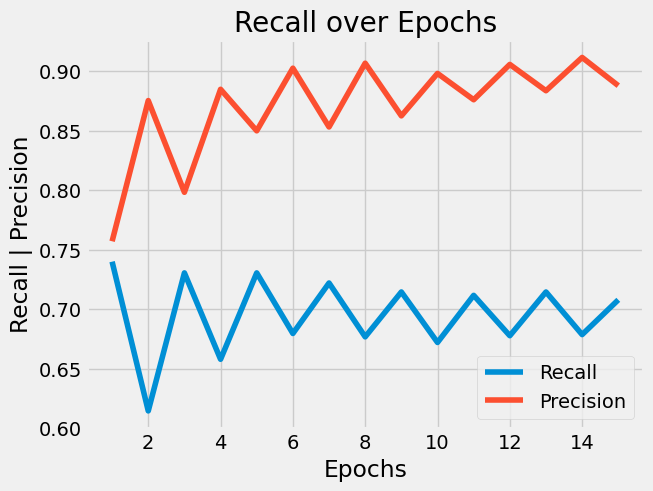

In [51]:
plt.plot(range(1, epochs+1), recall_value, label='Recall')
plt.plot(range(1, epochs+1), precision_value, label='Precision')

plt.xlabel('Epochs')  # or 'k value' or any x-axis label
plt.ylabel('Recall | Precision')
plt.title('Recall over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
knn = KNeighborsClassifier(n_neighbors = 13)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [53]:
print("Train accuracy: {:.3f}".format(knn.score(X_train, y_train)))
print("Val accuracy: {:.3f}".format(knn.score(X_val,   y_val)))
print("Test accuracy: {:.3f}".format(knn.score(X_test,  y_test)))

Train accuracy: 0.904
Val accuracy: 0.891
Test accuracy: 0.901


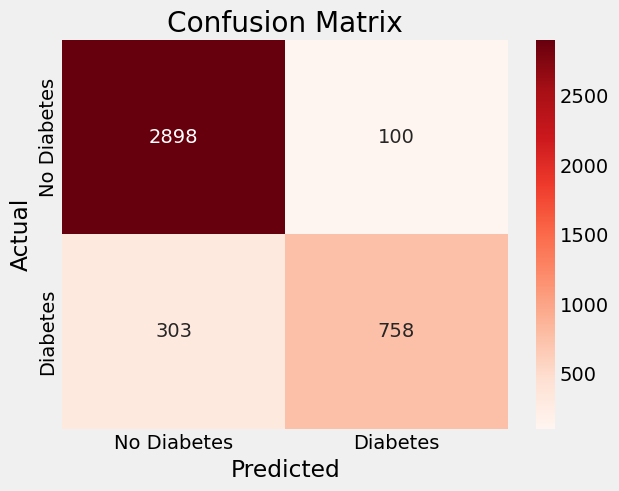

Precision: 0.88
Recall:    0.71
Accuracy:    0.90
F1 Score:    0.79


In [54]:
y_pred = knn.predict(X_test)
CM = confusion_matrix(y_test, y_pred)
labels = ['No Diabetes', 'Diabetes']
sns.heatmap(CM, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision: {:.2f}".format(precision))
print("Recall:    {:.2f}".format(recall))
print("Accuracy:    {:.2f}".format(accuracy))
print("F1 Score:    {:.2f}".format(f1))

In [55]:
################################### This model is used previously ########################################
dt = RandomForestClassifier(n_estimators=110, random_state=42, max_depth = 8, class_weight = {0:1, 1:4.9})
dt.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 4.9}, max_depth=8,
                       n_estimators=110, random_state=42)

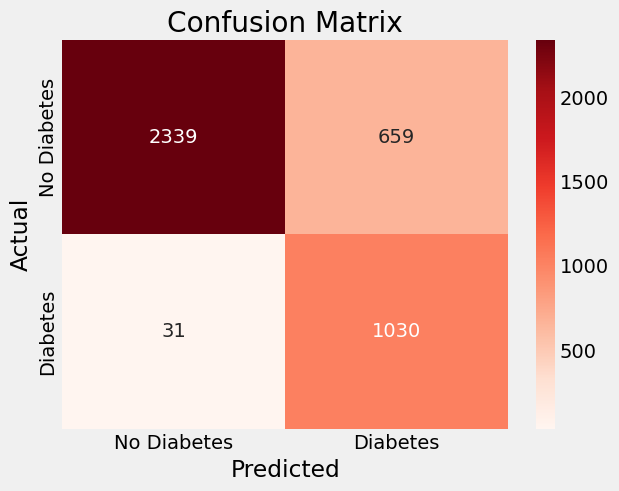

In [56]:
y_pred = dt.predict(X_test)
CM = confusion_matrix(y_test, y_pred)
labels = ['No Diabetes', 'Diabetes']

sns.heatmap(CM, annot=True, fmt='d', cmap='Reds',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [57]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision: {:.2f}".format(precision))
print("Recall:    {:.2f}".format(recall))
print("Accuracy:    {:.2f}".format(accuracy))
print("F1 Score:    {:.2f}".format(f1))

Precision: 0.61
Recall:    0.97
Accuracy:    0.83
F1 Score:    0.75


In [58]:
################################### This model is used Currently ########################################
#################### FINAL MODEL #################################################
model = XGBClassifier(
    n_estimators = 110,
    learning_rate = 0.1,
    max_depth = 4,
    use_label_encoder = True,
    scale_pos_weight = 1.9,
    early_stopping_rounds=10,
    eval_metric = 'logloss'
)
model.fit(
    X_train, y_train,
    eval_set = [(X_val, y_val)],
    verbose = True
)


[0]	validation_0-logloss:0.56618
[1]	validation_0-logloss:0.52307
[2]	validation_0-logloss:0.48744
[3]	validation_0-logloss:0.45655
[4]	validation_0-logloss:0.43014
[5]	validation_0-logloss:0.40695
[6]	validation_0-logloss:0.38680
[7]	validation_0-logloss:0.36878
[8]	validation_0-logloss:0.35297
[9]	validation_0-logloss:0.33891
[10]	validation_0-logloss:0.32670
[11]	validation_0-logloss:0.31553
[12]	validation_0-logloss:0.30534
[13]	validation_0-logloss:0.29594
[14]	validation_0-logloss:0.28773
[15]	validation_0-logloss:0.27975
[16]	validation_0-logloss:0.27309
[17]	validation_0-logloss:0.26717
[18]	validation_0-logloss:0.26110
[19]	validation_0-logloss:0.25622
[20]	validation_0-logloss:0.25162
[21]	validation_0-logloss:0.24704
[22]	validation_0-logloss:0.24301
[23]	validation_0-logloss:0.23970
[24]	validation_0-logloss:0.23553
[25]	validation_0-logloss:0.23216
[26]	validation_0-logloss:0.22961
[27]	validation_0-logloss:0.22680
[28]	validation_0-logloss:0.22423
[29]	validation_0-loglos

D:\Python 311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:57:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[45]	validation_0-logloss:0.20107
[46]	validation_0-logloss:0.20032
[47]	validation_0-logloss:0.19965
[48]	validation_0-logloss:0.19907
[49]	validation_0-logloss:0.19849
[50]	validation_0-logloss:0.19790
[51]	validation_0-logloss:0.19739
[52]	validation_0-logloss:0.19652
[53]	validation_0-logloss:0.19485
[54]	validation_0-logloss:0.19438
[55]	validation_0-logloss:0.19393
[56]	validation_0-logloss:0.19350
[57]	validation_0-logloss:0.19309
[58]	validation_0-logloss:0.19249
[59]	validation_0-logloss:0.19215
[60]	validation_0-logloss:0.19181
[61]	validation_0-logloss:0.19143
[62]	validation_0-logloss:0.19114
[63]	validation_0-logloss:0.18981
[64]	validation_0-logloss:0.18953
[65]	validation_0-logloss:0.18928
[66]	validation_0-logloss:0.18815
[67]	validation_0-logloss:0.18794
[68]	validation_0-logloss:0.18772
[69]	validation_0-logloss:0.18699
[70]	validation_0-logloss:0.18678
[71]	validation_0-logloss:0.18660
[72]	validation_0-logloss:0.18644
[73]	validation_0-logloss:0.18619
[74]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=110, n_jobs=None,
              num_parallel_tree=None, ...)

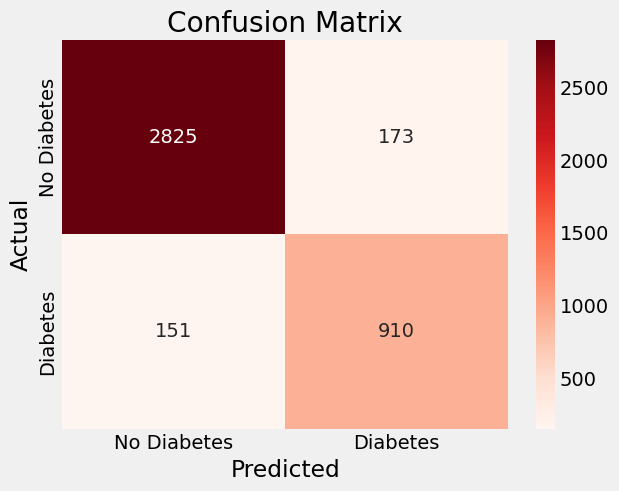

In [59]:
y_pred = model.predict(X_test)

CM = confusion_matrix(y_test, y_pred)
labels = ['No Diabetes', 'Diabetes']

sns.heatmap(CM, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [60]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision: {:.6f}".format(precision))
print("Recall:    {:.6f}".format(recall))
print("Accuracy:    {:.6f}".format(accuracy))
print("F1 Score:    {:.6f}".format(f1))

Precision: 0.840259
Recall:    0.857681
Accuracy:    0.920177
F1 Score:    0.848881


In [61]:
print("Train accuracy: {:.3f}".format(model.score(X_train, y_train)))
print("Val accuracy: {:.3f}".format(model.score(X_val,   y_val)))
print("Test accuracy: {:.6f}".format(model.score(X_test,  y_test)))

Train accuracy: 0.916
Val accuracy: 0.916
Test accuracy: 0.920177
